# Setup

In [1]:
import sys
sys.path.insert(
    0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')

In [2]:
import sys
sys.path.insert(0, '/home/563/esh563/TINT')

In [3]:
# Core
import datetime
import os
import glob
import tempfile
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
# import tint.animate
# from tint.visualisation import animate

import CPOL_func as cf
import caine_func as caf
import analysis

# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport tint.visualisation.figures
%aimport tint.visualisation.animate
%aimport tint.visualisation.horizontal_helpers
%aimport tint.visualisation.vertical_helpers
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport tint.matching
%aimport tint.rain
%aimport tint.cells
%aimport tint.tracks_helpers
%aimport tint.process_ERA5
%aimport tint.process_WRF

%pdb


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/graphml.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.int, "int"), (np.int8, "int"),
/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/gexf.py:220: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to us

Automatic pdb calling has been turned ON


In [41]:
base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'

In [15]:
base_dir = '/g/data/hj10/cpol/cpol_level_1b/v2020/gridded/grid_150km_2500m/'
save_dir = '/home/563/esh563/TINT_tracks/'
fig_dir = '/home/563/esh563/TINT_figures/'
ERA5_dir = '/g/data/rt52/era5/pressure-levels/reanalysis/'

In [42]:
dates = np.arange(
    np.datetime64('2005-11-13 14:00'), 
    np.datetime64('2005-11-13 20:00'),
    np.timedelta64(10, 'm'))

filenames, start_time, end_time = cf.CPOL_files_from_datetime_list(
    dates, base_dir=base_dir)

micro_physics = 'cpol'

tracks_obj  = tint.Tracks(params = {
    'AMBIENT': 'ERA5', 'AMBIENT_BASE_DIR': ERA5_dir,
    'GS_ALT': 1000,
    'LEVELS': np.array(
        [[1000, 1500], [500, 20000]]),
    'WIND_LEVELS': np.array(
        [[500, 3500], [500, 20000]]),
    'FIELD_THRESH': ['convective', 15],
    'MIN_SIZE': [80, 800],
    'ISO_THRESH': [10, 10],
    'AMBIENT': 'ERA5',
    'AMBIENT_BASE_DIR': ERA5_dir,
    'AMBIENT_TIMESTEP': 6})

Gathering files.


In [5]:
micro_physics = 'lin'

dates = np.arange(
    np.datetime64('2006-02-08 12:00'), 
    np.datetime64('2006-02-13 10:10'),
    np.timedelta64(10, 'm'))

filenames, start_time, end_time = caf.caine_files_from_datetime_list(
    dates, micro_physics=micro_physics, 
    base_dir=WRF_dir)

tracks_obj  = tint.Tracks(params={
    'AMBIENT': 'WRF', 'AMBIENT_BASE_DIR': WRF_dir + 'lind02/'})

Gathering files.


In [4]:
micro_physics = 'thompson'

dates = np.arange(
    np.datetime64('2006-02-08 12:00'), 
    np.datetime64('2006-02-13 10:10'),
    np.timedelta64(10, 'm'))

filenames, start_time, end_time = caf.caine_files_from_datetime_list(
    dates, micro_physics=micro_physics, 
    base_dir=WRF_dir)

tracks_obj  = tint.Tracks(params={
    'AMBIENT': 'WRF', 'AMBIENT_BASE_DIR': WRF_dir + 'thompsond02/'})

Gathering files.


# Create Tracks

In [43]:
b_path = '/home/student.unimelb.edu.au/shorte1/Documents/'
b_path += 'CPOL_analysis/circ_b_ind_set.pkl'
with open(b_path, 'rb') as f:
    b_ind_set = pickle.load(f)

In [44]:
def gen_tracks(tracks_obj, filenames, b_path=None):

    grids = (
        pyart.io.read_grid(fn, include_fields = ['reflectivity'])
        for fn in filenames)
    
      
    tracks_obj.get_tracks(grids, b_path=b_path)
        
    return tracks_obj

In [45]:
tracks_obj = gen_tracks(tracks_obj, filenames, b_path=b_path)

Getting ERA5 metadata.
Getting Intepolated ERA5 for next hour.
Writing tracks for scan 0.
Writing tracks for scan 1.
Writing tracks for scan 2.
Writing tracks for scan 3.
Writing tracks for scan 4.
Writing tracks for scan 5.
Writing tracks for scan 6.
Writing tracks for scan 7.
Writing tracks for scan 8.
Writing tracks for scan 9.
Writing tracks for scan 10.
Writing tracks for scan 11.
Writing tracks for scan 12.
Writing tracks for scan 13.
Writing tracks for scan 14.
Writing tracks for scan 15.
Writing tracks for scan 16.
Writing tracks for scan 17.
Writing tracks for scan 18.
Writing tracks for scan 19.
Writing tracks for scan 20.
Writing tracks for scan 21.
Writing tracks for scan 22.
Writing tracks for scan 23.
Getting Intepolated ERA5 for the next hour.
Writing tracks for scan 24.
Writing tracks for scan 25.
Writing tracks for scan 26.
Writing tracks for scan 27.
Writing tracks for scan 28.
Writing tracks for scan 29.
Writing tracks for scan 30.
Writing tracks for scan 31.
Writing

Generating figure for 2005-11-13T19:20.


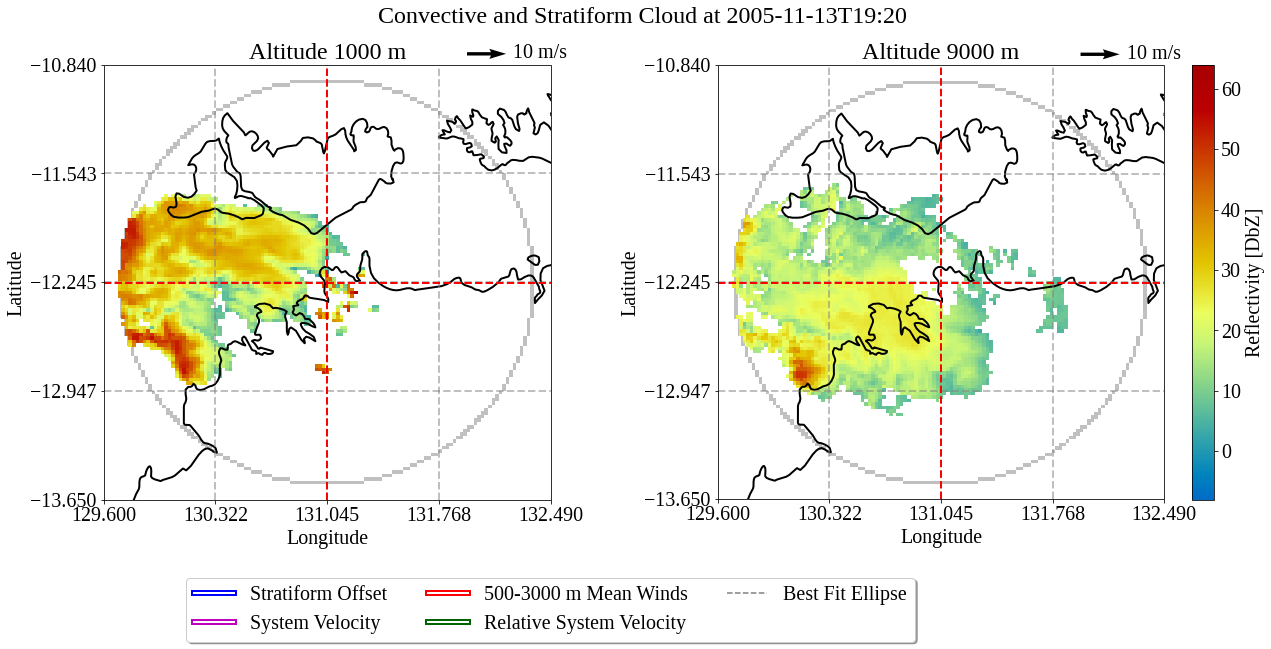

In [85]:
filename = filenames[32]
grid = pyart.io.read_grid(filename, include_fields=['reflectivity'])

current_time = str(datetime.datetime.now())[0:-7]
current_time = current_time.replace(" ", "_").replace(":", "_")
current_time = current_time.replace("-", "")

# filename = filenames[95]
# grid = pyart.io.read_grid(filename, include_fields=['reflectivity'])

# ACCESS_refl = tint.process_ACCESS.

current_time = str(datetime.datetime.now())[0:-7]
current_time = current_time.replace(" ", "_").replace(":", "_")
current_time = current_time.replace("-", "")

params = {
    'uid_ind': None, 'line_coords': False, 'center_cell': False,
    'cell_ind': 10, 'winds': False,
    'crosshair': True, 'fontsize': 20, 'colorbar_flag': True,
    'leg_loc': 2, 'label_type': 'velocities',
    'system_winds': ['shift', 'ambient_mean', 'relative'],
    'boundary': True, 'exclude': True}

tint.visualisation.figures.two_level(
    tracks_obj, grid, params=params, alt1=1000, alt2=9000)
plt.savefig(
    fig_dir + '/test_{}.png'.format(current_time), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

In [9]:
current_time = str(datetime.datetime.now())[0:-7]
current_time = current_time.replace(" ", "_").replace(":", "_")
current_time = current_time.replace("-", "")
out_file_name = save_dir + 'cpol_2005_2006.pkl'.format(
    micro_physics, current_time)
with open(out_file_name, 'wb') as f:
    pickle.dump(tracks_obj, f)

In [46]:
tracks_obj = tint.objects.classify_tracks(tracks_obj)
tracks_obj = tint.objects.get_exclusion_categories(tracks_obj)

In [8]:
with open(save_dir + 'cpol_2005_2006.pkl', 'rb') as f:
    tracks_obj = pickle.load(f)

In [9]:
tracks_obj.params

{'SEARCH_MARGIN': 50000,
 'FLOW_MARGIN': 40000,
 'MAX_FLOW_MAG': 60,
 'MAX_DISPARITY': 999,
 'MAX_SHIFT_DISP': 60,
 'ISO_SMOOTH': 3,
 'GS_ALT': 1500,
 'LEVELS': array([[  500,  3500],
        [ 3500,  7500],
        [ 7500, 10000]]),
 'MIN_SIZE': [80, 400, 800],
 'FIELD_THRESH': ['convective', 20, 15],
 'ISO_THRESH': [10, 10, 10],
 'TRACK_INTERVAL': 0,
 'CELL_THRESH': 25,
 'CELL_START': 3000,
 'RAIN': False,
 'SAVE_RAIN': False,
 'AMBIENT': 'ERA5',
 'AMBIENT_BASE_DIR': "/media/shorte1/Ewan's Hard Drive/phd/data/era5/pressure-levels/reanalysis/",
 'CLASS_THRESH': {'OFFSET_MAG': 5000,
  'SHEAR_MAG': 1,
  'VEL_MAG': 1,
  'REL_VEL_MAG': 1,
  'ANGLE_BUFFER': 0.17453292519943295},
 'EXCL_THRESH': {'SMALL_AREA': 500,
  'LARGE_AREA': 50000,
  'BORD_THRESH': 0.01,
  'MAJOR_AXIS_LENGTH': 100,
  'AXIS_RATIO': 3},
 'BOUNDARY_GRID_CELLS': {(0, 48),
  (0, 49),
  (0, 50),
  (0, 51),
  (0, 52),
  (0, 53),
  (0, 54),
  (0, 55),
  (0, 56),
  (0, 57),
  (0, 58),
  (0, 59),
  (0, 60),
  (0, 61),
  (0, 62)

In [11]:
def fill_end(group_df):
    import pdb; pdb.set_trace()
    group_df[['u_shift', 'v_shift']].iloc[-1] = group_df[['u_shift', 'v_shift']].iloc[-2]
    

In [12]:
tracks_obj.tracks.groupby(level=['uid', 'level']).apply(
        lambda x: fill_end(x))

> /tmp/ipykernel_31696/4190406837.py(3)fill_end()
      1 def fill_end(group_df):
      2     import pdb; pdb.set_trace()
----> 3     group_df[['u_shift', 'v_shift']].iloc[-1] = group_df[['u_shift', 'v_shift']].iloc[-2]
      4 

ipdb> group_df['u_shift'].iloc[-1]
-4.16
ipdb> group_df['u_shift'].iloc[-1] = 5
ipdb> group_df['u_shift'].iloc[-1]
5.0
ipdb> q


BdbQuit: 

> /home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/bdb.py(113)dispatch_line()
    111         if self.stop_here(frame) or self.break_here(frame):
    112             self.user_line(frame)
--> 113             if self.quitting: raise BdbQuit
    114         return self.trace_dispatch
    115 

ipdb> q


In [11]:
tracks_obj.tracks_class['offset_type']

scan  time                 level  uid
26    2006-02-13 04:20:00  0      0      Parallel 
                           1      0      Parallel 
                           2      0      Parallel 
27    2006-02-13 04:30:00  0      0      Parallel 
                           1      0      Parallel 
                                           ...    
109   2006-02-13 18:20:00  1      6      Trailing 
                           2      6      Trailing 
110   2006-02-13 18:30:00  0      6      Trailing 
                           1      6      Trailing 
                           2      6      Trailing 
Name: offset_type, Length: 186, dtype: object

In [15]:
tracks_obj.tracks_class

grid_x         grid_y        lon  \
scan time                level uid                                           
26   2006-02-13 04:20:00 0     0    94258.747101   91626.815796  131.90924   
                         1     0    93731.021881   89518.089294  131.90446   
                         2     0    94601.573944   90367.965698  131.91242   
27   2006-02-13 04:30:00 0     0    94103.031158   93521.881104  131.90776   
                         1     0    91883.563995   89156.665802  131.88752   
...                                          ...            ...        ...   
109  2006-02-13 18:20:00 1     6   -42433.776855 -111225.147247  130.65241   
                         2     6   -39183.788300 -115186.266899  130.68239   
110  2006-02-13 18:30:00 0     6   -59737.138748 -104407.777786  130.49269   
                         1     6   -47207.069397 -108781.957626  130.60835   
                         2     6   -44592.847824 -111780.140400  130.63246   

                                         lat inflow_type  \
scan time                level uid                         
26   2006-02-13 04:20:00 0     0   -11.42382    Rear Fed   
                         1     0   -11.44280    Rear Fed   
                         2     0   -11.43513   Ambiguous   
27   2006-02-13 04:30:00 0     0   -11.40678    Rear Fed   
                         1     0   -11.44610    Rear Fed   
...                                      ...         ...   
109  2006-02-13 18:20:00 1     6   -13.24915   Front Fed   
                         2     6   -13.28482   Front Fed   
110  2006-02-13 18:30:00 0     6   -13.18757   Front Fed   
                         1     6   -13.22712   Front Fed   
                         2     6   -13.25412   Front Fed   

                                          propagation_type          tilt_type  \
scan time                level uid                                              
26   2006-02-13 04:20:00 0     0      Up-Shear Propagating  Ambiguous (Small    
                         1     0    Down-Shear Propagating  Ambiguous (Small    
                         2     0    Ambiguous (Low Relativ  Ambiguous (Small    
27   2006-02-13 04:30:00 0     0      Up-Shear Propagating  Ambiguous (Small    
                         1     0    Down-Shear Propagating  Ambiguous (Small    
...                                                    ...                ...   
109  2006-02-13 18:20:00 1     6      Up-Shear Propagating  Down-Shear Tilted   
                         2     6      Up-Shear Propagating  Down-Shear Tilted   
110  2006-02-13 18:30:00 0     6    Down-Shear Propagating    Up-Shear Tilted   
                         1     6      Up-Shear Propagating  Down-Shear Tilted   
                         2     6      Up-Shear Propagating  Down-Shear Tilted   

                                   offset_type  
scan time                level uid              
26   2006-02-13 04:20:00 0     0     Parallel   
                         1     0     Parallel   
                         2     0     Parallel   
27   2006-02-13 04:30:00 0     0     Parallel   
                         1     0     Parallel   
...                                        ...  
109  2006-02-13 18:20:00 1     6     Trailing   
                         2     6     Trailing   
110  2006-02-13 18:30:00 0     6     Trailing   
                         1     6     Trailing   
                         2     6     Trailing   

[186 rows x 8 columns]

In [36]:
test = copy.deepcopy(tracks_obj.tracks)
inflow_cond = (
    tracks_obj.system_tracks['x_vert_disp'] * tracks_obj.tracks['u_shear']
    + tracks_obj.system_tracks['y_vert_disp'] * tracks_obj.tracks['v_shear'])

In [41]:
u_shear

scan  time                 level  uid
26    2006-02-13 04:20:00  0      0     -6.00483
                           1      0      2.92783
                           2      0      2.61377
27    2006-02-13 04:30:00  0      0     -6.07322
                           1      0      3.06301
                                          ...   
109   2006-02-13 18:20:00  1      6      3.84559
                           2      6      3.51672
110   2006-02-13 18:30:00  0      6     -8.69906
                           1      6      3.89933
                           2      6      3.51533
Name: u_shear, Length: 186, dtype: float64

In [43]:
x_offset

scan  time                 uid
26    2006-02-13 04:20:00  0        342.826843
27    2006-02-13 04:30:00  0       -160.064697
28    2006-02-13 04:40:00  0       4056.358337
29    2006-02-13 04:50:00  0       5448.055267
30    2006-02-13 05:00:00  0       7804.946899
                                      ...     
106   2006-02-13 17:50:00  6      13907.232285
107   2006-02-13 18:00:00  6      24080.314636
108   2006-02-13 18:10:00  6      11994.714737
109   2006-02-13 18:20:00  6      16506.528854
110   2006-02-13 18:30:00  6      15144.290924
Name: x_vert_disp, Length: 62, dtype: float64

In [40]:
tracks_obj.system_tracks['x_vert_disp'] * tracks_obj.tracks['u_shear']

scan  time                 uid  level
26    2006-02-13 04:20:00  0    0         -2058.616913
                                1          1003.738717
                                2           896.070518
27    2006-02-13 04:30:00  0    0           972.108121
                                1          -490.279768
                                             ...      
109   2006-02-13 18:20:00  6    1         63477.342297
                                2         58048.840153
110   2006-02-13 18:30:00  6    0       -131741.095406
                                1         59052.587929
                                2         53237.180214
Length: 186, dtype: float64